### Classifiers and Regressors

#### Classifiers and Regressors help cells

In [1]:
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import numpy as np
import random
import pandas as pd
import seaborn as sns

In [2]:
# datasets: list of datasets or single dataset, depending on if multiple_datasets is set to True
# make_categorical_data: transform numeric -1, 0, 1 data to categorical data, for each dimension 2 new ones, 
#       one with either SIMP/NOT_SIMP and one for ABSTAIN
# use1249LFs: use the fully unpruned dataset
def load_data(datasets, make_categorical_data, use1249LFs=False, multiple_datasets=False):
    src = []
    simp = []
    labels = []

    if not multiple_datasets:
        datasets = [datasets]

    for d_s in datasets:    
        if use1249LFs:
            simp_path = f"/workspace/datasets/ds_labels/{d_s}-1249_simp_labels.pkl"        
            src_path = f"/workspace/datasets/ds_labels/{d_s}-1249_src_labels.pkl"  
        else:
            simp_path = f"/workspace/datasets/ds_labels/{d_s}_simp_labels.pkl"        
            src_path = f"/workspace/datasets/ds_labels/{d_s}_src_labels.pkl"  

        simp_labels = pickle.load(open(simp_path, "rb"))
        src_labels = pickle.load(open(src_path, "rb")) 

        for entry in simp_labels:
            src.append([number for number in entry.tolist()])

        for entry in src_labels:
            simp.append([number for number in entry.tolist()])

        curr_lab = [0] * len(simp_labels) + [1] * len(simp_labels)
        labels = labels + curr_lab
        
    # load textual data
    if d_s == 'EW-SEW-Turk':
        textual_dataset = pd.read_pickle('/workspace/datasets/ewsewturk/ewsewturk.pkl')
    else: 
        if d_s == 'SemEval_2007':    
            textual_dataset = pd.read_pickle('/workspace/datasets/semeval07/semeval07.pkl')
        else:
            if d_s == 'SimpEval_22':
                textual_dataset = pd.read_pickle('/workspace/datasets/simpeval/simpeval.pkl')
            else:
                textual_dataset = pd.read_pickle('/workspace/datasets/' + d_s + '/' + d_s + '.pkl')

    simp_dup = ~textual_dataset['simp'].duplicated()
    src_dup =  ~textual_dataset['src'].duplicated()

    dups = simp_dup & src_dup
    
    num_left = sum(dups)

    data_merged_simp_dedup = []
    data_merged_src_dedup = []
    texts = []

    labels_dedup = []

    for index, val in dups.items():
        if val:
            data_merged_simp_dedup.append(simp[index])
            texts.append(textual_dataset['simp'].iloc[index])
            data_merged_src_dedup.append(src[index])
            texts.append(textual_dataset['src'].iloc[index])


    labels_dedup = [0] * num_left + [1] * num_left

    X, y, texts = shuffle(data_merged_simp_dedup + data_merged_src_dedup, labels_dedup, texts, random_state=42)

    with open("/workspace/datasets/" + datasets[0] + "_texts.pkl", "wb") as output_file:
        pickle.dump(texts, output_file)

    return X, y

In [3]:
X, y = load_data('BenchLS', make_categorical_data=False, use1249LFs=True)
print(len(X))

1856


In [4]:
clf_gb = GradientBoostingClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)

clfs = {'gb': clf_gb, 'rf': clf_rf}

reg_gb = GradientBoostingRegressor(random_state=42)
reg_rf = RandomForestRegressor(random_state=42)
reg_mlp = MLPRegressor(random_state=42)

regs = {'reg_gb': reg_gb, 'reg_rf': reg_rf, 'reg_mlp': reg_mlp}

In [5]:
def run_classifiers(run, X, y, run_type, n=10):
    if run:
        output = ''
        kfold = KFold(n_splits=n, shuffle=True, random_state=42)
        for clf in clfs:
            cv_scores = cross_val_score(clfs[clf], X, y, cv=kfold)
            output += clf + ' (' + run_type + ') : '
            output += str(sum(cv_scores)/len(cv_scores)) + '\n'
            output += str(cv_scores) + '\n___\n'
        return output, sum(cv_scores)/len(cv_scores)
    return '', 0

def run_single_classifier(X_train, y_train, clf_name, n, X_test=None, y_test=None):
    score = -1
    curr_clf = clfs[clf_name].fit(X_train, y_train)

    if X_test and y_test:
        score = curr_clf.score(X_test, y_test)
    else:
        X_test = X_train
        y_test = y_train

    # find dimensions of most important LFs
    perm_importance = permutation_importance(curr_clf, X_test, y_test).importances_mean
    if n < 0:
        return perm_importance, score
    top_LFs = np.argsort(perm_importance)[::-1][:n]

    return top_LFs, score

def get_importance_of_single_class(X_train, y_train):
    curr_clf = clfs['rf'].fit(X_train, y_train)

    # find dimensions of most important LFs
    perm_importance = permutation_importance(curr_clf, X_train, y_train).importances_mean

    return perm_importance


def run_regressors(run, X, y, n):
    if run:
        output = ''
        kfold = KFold(n_splits=n, shuffle=True, random_state=42)
        for reg in regs:
            cv_scores = cross_val_score(regs[reg], X, y, cv=kfold)
            output += reg + ': '
            output += str(sum(cv_scores)/len(cv_scores)) + '\n'
            output += str(cv_scores) + '\n___\n'
        return output, sum(cv_scores)/len(cv_scores)
    return '', 0

In [6]:
# datasets: list of datasets or single dataset, depending on if multiple_datasets is set to True
# make_categorical_data: transform numeric -1, 0, 1 data to categorical data, for each dimension 2 new ones, 
#       one with either SIMP/NOT_SIMP and one for ABSTAIN
# use1249LFs: use the fully unpruned dataset
def load_200_data(datasets, make_categorical_data, use1249LFs=False, multiple_datasets=False):
    if not multiple_datasets:
        datasets = [datasets]

    data_merged_dedup = []
    labels_dedup = []


    for d_s in datasets:    
        data_merged_simp_dedup = []
        data_merged_src_dedup = []

        data_merged_simp = []
        data_merged_src = []
        
        if use1249LFs:
            simp_path = f"/workspace/datasets/ds_labels/{d_s}-1249_simp_labels.pkl"        
            src_path = f"/workspace/datasets/ds_labels/{d_s}-1249_src_labels.pkl"  
        else:
            simp_path = f"/workspace/datasets/ds_labels/{d_s}_simp_labels.pkl"        
            src_path = f"/workspace/datasets/ds_labels/{d_s}_src_labels.pkl"  

        random.seed(42)
        simp_labels = pickle.load(open(simp_path, "rb"))
        src_labels = pickle.load(open(src_path, "rb"))

        for entry in simp_labels:
            data_merged_simp.append([number for number in entry.tolist()])

        for entry in src_labels:
            data_merged_src.append([number for number in entry.tolist()])


        # load textual data
        if d_s == 'EW-SEW-Turk':
            textual_dataset = pd.read_pickle('/workspace/datasets/ewsewturk/ewsewturk.pkl')
        else: 
            if d_s == 'SemEval_2007':    
                textual_dataset = pd.read_pickle('/workspace/datasets/semeval07/semeval07.pkl')
            else:
                if d_s == 'SimpEval_22':
                    textual_dataset = pd.read_pickle('/workspace/datasets/simpeval/simpeval.pkl')
                else:
                    textual_dataset = pd.read_pickle('/workspace/datasets/' + d_s + '/' + d_s + '.pkl')
        
        dups_simp = textual_dataset['simp'].duplicated()
        dups_src = textual_dataset['src'].duplicated()




        for index, val in dups_simp.items():
            if val == False:
                data_merged_simp_dedup.append(data_merged_simp[index])

        for index, val in dups_src.items():
            if val == False:
                data_merged_src_dedup.append(data_merged_src[index])

        curr_min = min(100, min(len(data_merged_simp_dedup), len(data_merged_src_dedup)))

        labels_dedup += [0] * curr_min + [1] * curr_min

        data_merged_dedup += shuffle(data_merged_simp_dedup, random_state=42)[:curr_min] + shuffle(data_merged_src_dedup, random_state=42)[:curr_min]

    X, y = shuffle(data_merged_dedup, labels_dedup, random_state=42)

    return X, y

#### Classifiers and Regressors run

In [14]:
def run():
    datasets = ['ASSET'] #'britannica', 'ASSET', 'MTurkSF', 'Wiki-Manual','eval'

    #datasets = ['ASSET', 'AutoMeTS', 'BenchLS', 'britannica', 'EW-SEW-Turk', 'HutSSF', 
    #            'metaeval', 'MTurkSF', 'NNSeval', 'OneStopEnglish', 'QuestEval', 'SemEval_2007',
    #            'SimpEval_22', 'simpa', 'TurkCorpus']

    n = 10

    X, y = load_data(datasets, make_categorical_data=False, use1249LFs=True, multiple_datasets=True)

    print(len(X))

    with open("/workspace/datasets/embeddings/ASSET_X.pkl", "rb") as output_file:
        new_X = pickle.load(output_file)

   
    #print(run_classifiers(True, X, y, 'vanilla', n)[0])

    print(run_classifiers(True, new_X, y, 'vanilla', n)[0])
    print(run_regressors(False, X, y, n)[0])

run()

4718
gb (vanilla) : 0.6803721796394255
[0.69067797 0.70974576 0.66525424 0.6970339  0.65889831 0.64618644
 0.68855932 0.69067797 0.67515924 0.68152866]
___
rf (vanilla) : 0.8592667062506747
[0.86652542 0.88771186 0.83898305 0.84957627 0.84110169 0.87076271
 0.83262712 0.86652542 0.88747346 0.85138004]
___




### Feature Selection

#### Feature Selection help cells

In [6]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
def prep_naive_approach(X, y):
    dims_to_include = []
    
    # only include dimensions where values are the most different 
    for lf_dim in range(len(X[0])):
        sum_i_src = 0
        sum_i_simp = 0
        for d_p in range(len(X)):
            if y[d_p] == 0:
                sum_i_simp += abs(X[d_p][lf_dim])
            else:
                sum_i_src += abs(X[d_p][lf_dim])

        dist = abs(sum_i_simp - sum_i_src)
        
        dims_to_include.append((dist, lf_dim))
    
    dims_to_include.sort(reverse=True)

    return dims_to_include

def prep_mean_importance(X, y, n, clf_name):
    kfold = KFold(n_splits=n, shuffle=True, random_state=42)

    feature_importances = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = np.take(X, train_index, axis=0), np.take(X, test_index, axis=0)
        y_train, y_test = np.take(y, train_index), np.take(y, test_index)

        curr_clf = clfs[clf_name]
        curr_clf.fit(X_train, y_train)

        perm_importance = permutation_importance(curr_clf, X_test, y_test)
        feature_importances.append(perm_importance.importances_mean)
    return feature_importances


# naive_categorical_tuples: if using the naive_feature_selection_count and make_categorical_data and 1 dim of the 2 belonging together is chosen,
#       should the two dimensions both be considered together in the resulting dimensions
def run_naive_feature_selection(X, k, naive_categorical_tuples, dims_to_include):    

    # cut off to top k
    dims_to_include = dims_to_include[:k]
    dims_to_include.sort(key=lambda a: a[1])

    X_naive = []
    for d_p in range(len(X)):
        new_dp = []
        all_bases = []
        for inc_dims in dims_to_include:
            if naive_categorical_tuples:
                # check if dim has already been included
                base = int(inc_dims[0] / 2)
                if base not in all_bases:
                    all_bases.append(base)
                    base_dim = 2 * base

                    new_dp.append(X[d_p][base_dim])
                    new_dp.append(X[d_p][base_dim + 1])
            else:
                new_dp.append(X[d_p][inc_dims[1]])

        X_naive.append(new_dp)
    return X_naive

def run_chi2(X, y, k):
    X_chi2 = SelectKBest(chi2, k=k).fit_transform(X, y)
    return X_chi2

def run_mean_importance(X, k, feature_importances):
    mean_importance = np.mean(feature_importances, axis=0)
    sorted_indices = np.argsort(mean_importance)[::-1]
    top_k_indices = sorted_indices[:k]

    X_mean_importance = []

    for dp in X:
        new_dp = []
        for dim in top_k_indices:
            new_dp.append(dp[dim])
        X_mean_importance.append(new_dp)
    return X_mean_importance

def run_random(X, y, k):
    dims_to_include = shuffle(range(0, len(X[0]) - 1), random_state=42)[:k]

    X_random = []

    for d_p in range(len(X)):
        new_dp = []
        for inc_dims in dims_to_include:
            new_dp.append(X[d_p][inc_dims])
        X_random.append(new_dp)
    return X_random

#### Feature Selection run

In [ ]:
def run_feature_selection(X, y, n, clf_name, lower=10, upper=-1, thres=-1):
    if upper == -1:
        upper = len(X[0])-1
    all_res = []

    print('prep started')
    dims_to_include = prep_naive_approach(X, y)
    print('naive prepped')
    feature_importances = prep_mean_importance(X, y, n, clf_name)
    print('prep done')

    for i in tqdm(range(lower, upper, 10)):
        num_cat = i
        
        if len(X[0]) < num_cat:
            print('Error: Number of categories smaller than dimensions of input data!')
            exit()

        X_naive = run_naive_feature_selection(X, num_cat, False, dims_to_include)
        X_chi2 = run_chi2(X, y, num_cat)
        X_mean_importance = run_mean_importance(X, num_cat, feature_importances)
        X_random = run_random(X, y, num_cat)

        naive_score = run_classifiers(True, X_naive, y, 'naive' + '_' + str(num_cat), n)[1]
        chi_score = run_classifiers(True, X_chi2, y, 'chi2' + '_' + str(num_cat), n)[1]
        meanImp_score = run_classifiers(True, X_mean_importance, y, 'mean importance_' + str(num_cat), n)[1]
        rand_score = run_classifiers(True, X_random, y, 'random' + '_' + str(num_cat), n)[1]

        all_res.append([naive_score, chi_score, meanImp_score, rand_score])

        found = 0

        if len(all_res) >= 3:
            for meth in range(4):
                if all_res[len(all_res)-1][meth] > thres and all_res[len(all_res)-2][meth] > thres and all_res[len(all_res)-3][meth] > thres:
                    found+= 1

            if found == 4:
                return all_res, lower, i

    return all_res, lower, upper

#### Feature Selection Visualisation

In [7]:
!pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
import pickle as pkl
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


In [9]:
def save_visualisation(all_res, ds_name, newly_generated = False):
    if newly_generated:
        with open('/workspace/datasets/performance_of_features/' + ds_name + '_performance_of_feature_selection.pkl', 'wb') as f:
            pickle.dump(all_res, f)
    else:
        all_res = pd.read_pickle('/workspace/datasets/performance_of_features/' + ds_name + '_performance_of_feature_selection.pkl')
    return all_res

def run_visualisation(all_res, ds_name, lower=10, upper=-1, thres=-1, maximum=-1):
    df = pd.DataFrame(all_res, index=range(lower, upper, 10), columns=['naive approach', 'chi2', 'mean importance', 'random'])
    sns.lineplot(data=df).set(title=ds_name, xlabel='Number of Dimensions', ylabel='Mean Accuracy')
    sns.set(rc = {'figure.figsize':(7,5)})

    plt.axhspan(thres, maximum, facecolor='gray', alpha=0.25)    


In [ ]:
all_res = save_visualisation([], 'simpa', newly_generated=False)
maximum =  0.7342
thres = 0.9 * maximum

res_all_res = []

found = 0
first = 1249
last = -1
for index in range(len(all_res)):
    if index < 3:
        res_all_res.append(all_res[index])

    found = 0

    if index > 2 and last == -1:
        res_all_res.append(all_res[index])

        for meth in range(4):
            if all_res[index][meth] > thres and all_res[index - 1][meth] > thres and all_res[index - 2][meth] > thres:
                found+= 1
        
        if found > 0 and index < first:
            first = index

        if found == 4:
            last = index

print(first)
print(last)

run_visualisation(res_all_res, 'SIMPA', 10, last * 10 +11, thres, maximum)

In [ ]:
for curr_ds_name in ['QuestEval']:
    Xcurr, ycurr = load_data(curr_ds_name, make_categorical_data=False, use1249LFs=True)
    maximum = 0.899
    thres=maximum*0.9

    all_res, lower, upper = run_feature_selection(Xcurr, ycurr, 10, 'rf', lower=10, upper=1249, thres=thres)

    save_visualisation(all_res, curr_ds_name, newly_generated=True)
    
    run_visualisation(all_res, curr_ds_name, lower, upper +1, thres, maximum)

### Find most important LF per Dataset

In [ ]:
clf_name = 'gb'

In [ ]:
datasets = [] #['MTurkSF']#, 'simpa']
top_dims_single = []

for ds in datasets:
    X, y = load_data(ds, make_categorical_data=False, use1249LFs=True)
    topLFs, score = run_single_classifier(X, y, clf_name, -1)
    top_dims_single.append(topLFs)

#### Rank correlation

In [ ]:
def calc_dim_imp(datasets, clf_name):
    top_LFs_of_all_ds = {}

    for a in datasets:
        X, y = load_data(a, make_categorical_data=False, use1249LFs=True)
        topLFs, score = run_single_classifier(X, y, clf_name, -1)
        top_LFs_of_all_ds[a] = topLFs

    return top_LFs_of_all_ds

def prune_dims(datasets, top_LFs_of_all_ds, k):
    only_top_LFs_of_all_ds = {}

    for a in datasets:
        sorted = np.argsort(top_LFs_of_all_ds[a])[::-1]
        top_k_indices = sorted[:k]
        pruned_values = []
        for dim in range(len(top_LFs_of_all_ds[a])):
            if dim in top_k_indices:
                pruned_values.append(top_LFs_of_all_ds[a][dim])
            else:
                pruned_values.append(0)
        
        only_top_LFs_of_all_ds[a] = pruned_values
    
    return only_top_LFs_of_all_ds

def calc_spearman(datasets, top_LFs_of_all_ds):
    spears = []
    for a in range(len(datasets)):
        for b in range(a + 1, len(datasets)):
            res = stats.spearmanr(top_LFs_of_all_ds[datasets[a]], top_LFs_of_all_ds[datasets[b]])
            #print(datasets[a] + ' - ' + datasets[b] + ': ' +  str(res.statistic))
            spears.append(res.statistic)
    return sum(spears)/len(spears)

def calc_overlap(datasets, top_LFs_of_all_ds, num_dims):
    if len(datasets) > 1:
        overlaps = []
        for a in range(len(datasets)):
            for b in range(a + 1, len(datasets)):
                # iterate through all dimensions to calculate overlap
                identical_dims = 0
                for i in range(len(top_LFs_of_all_ds[datasets[a]])):

                    if top_LFs_of_all_ds[datasets[a]][i] > 0 and top_LFs_of_all_ds[datasets[b]][i] > 0:
                        identical_dims += 1

                overlaps.append(identical_dims/num_dims)
        return sum(overlaps)/len(overlaps)
    else:
        return 0

def calc_thresless_overlap(datasets, top_LFs_of_all_ds, num_dims, name_to_thresless, dims_to_names):
    overlaps = []
    dataset_LFs = {}
    for a in range(len(datasets)):
        for i in range(len(top_LFs_of_all_ds[datasets[a]])):
            if top_LFs_of_all_ds[datasets[a]][i] > 0:
                if a not in dataset_LFs:
                    dataset_LFs[a] = []
                for actual_lf in dims_to_names[i]:
                    dataset_LFs[a].append(name_to_thresless[actual_lf])

    for a in range(len(datasets)):            
        for b in range(a + 1, len(datasets)):
            #print(num_dims)
            #print(dataset_LFs[a])
            #print(dataset_LFs[b])
            intersection_a = [x for x in dataset_LFs[a] if x in dataset_LFs[b]]
            intersection_b = [x for x in dataset_LFs[b] if x in dataset_LFs[a]]

            #print(len(intersection_a))
            #print(len(intersection_b))
            #print((len(intersection_a) + len(intersection_b))/(len(dataset_LFs[a]) + len(dataset_LFs[b])))
            #print('_____')
            overlaps.append(min(len(intersection_a), len(intersection_b))/len(dataset_LFs[a]))
    return sum(overlaps)/len(overlaps)

def draw_data(df, t, y):
    sns.lineplot(data=df).set(title=t, xlabel='Number of Dimensions', ylabel=y)

In [ ]:
datasets = ['BenchLS', 'britannica', 'HutSSF', 'MTurkSF', 'NNSeval', 'SemEval_2007', 'simpa', 'Wiki-Manual']

top_LFs_of_all_ds_GB = calc_dim_imp(datasets, clf_name)

In [ ]:
#top_LFs_of_all_ds_RF = top_LFs_of_all_ds

In [ ]:
calc_spearman(datasets, top_LFs_of_all_ds_GB)

In [ ]:
data = {}
for i in range(1249):
    only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, i)
    val = calc_spearman(datasets, only_top_LFs_of_all_ds)
    data[i] = val

In [ ]:
draw_data(data, 'Avg pairwise Spearman for different numbers of dimensions', 'Spearman')

In [ ]:
datasets = [] #[['MTurkSF', 'simpa'], ['simpa', 'MTurkSF']]
top_dims_merge = []
scores = []

for ds in datasets:
    X, y = load_data(ds[0], make_categorical_data=False, use1249LFs=True)
    X2, y2 = load_data(ds[1], make_categorical_data=False, use1249LFs=True)
    topLFs, score = run_single_classifier(X, y, clf_name, -1, X2, y2)
    top_dims_merge.append(topLFs)
    scores.append(score)

In [ ]:
top_dims_merge

In [ ]:
scores

In [ ]:
# todo: Berechne Overlap
data_overlap = {}
for i in range(1, 1249):
    only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, i)
    val = calc_overlap(datasets, only_top_LFs_of_all_ds, i)
    data_overlap[i] = val

In [ ]:
draw_data(data_overlap, 'Avg pairwise overlap for different numbers of dimensions', 'Overlap')

### Mapping of LFs to thresless and categories

In [20]:
from matcher import get_mapping_of_LF_and_dims

/usr/local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


resources get initialised


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dims_to_names, names_to_dims, name_to_thresless, name_to_category = get_mapping_of_LF_and_dims()
datasets = ['BenchLS', 'britannica', 'HutSSF', 'MTurkSF', 'NNSeval', 'SemEval_2007', 'simpa', 'Wiki-Manual']

In [ ]:
# most important dims per dataset
only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, 10)
for a in datasets:
    LFs = set()
    for i in range(1249):
        if only_top_LFs_of_all_ds[a][i] > 0:
            LFs.add(dims_to_names[i][0])
    print(a + ' ' + str(len(LFs)))
    print(LFs)

In [ ]:
# most important dims per dataset
dataset_LFs = {}
only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, 10)
for a in datasets:
    LFs = set()
    for i in range(1249):
        if only_top_LFs_of_all_ds[a][i] > 0:
            LFs.add(name_to_thresless[dims_to_names[i][0]])
            
    print(a + ' ' + str(len(LFs)))
    print(LFs)
    dataset_LFs[a] = LFs

In [ ]:
# todo: Berechne Overlap
data_overlap = {}
for i in range(1, 1250):
    only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, i)
    val = calc_thresless_overlap(datasets, only_top_LFs_of_all_ds, i, name_to_thresless, dims_to_names)
    data_overlap[i] = val

In [ ]:
draw_data(data_overlap, 'Avg pairwise overlap for different numbers of dimensions for thressless LFs', 'Overlap')

### Heatmap of importance of parametrizations

In [30]:

single_ds = ['ASSET', 'AutoMeTS', 'BenchLS', 'britannica', 'EW-SEW-Turk', 'HutSSF', 
            'metaeval', 'MTurkSF', 'NNSeval', 'OneStopEnglish', 'QuestEval', 'SemEval_2007',
            'SimpEval_22', 'simpa', 'TurkCorpus']

names = single_ds

all_X = {}
all_y = {}
for ds in single_ds:
    X, y = load_data(ds, make_categorical_data=False, use1249LFs=True, multiple_datasets=False)
    all_X[ds] = X 
    all_y[ds] = y

# general, ta_children, ta_language, d_medical, d_news, d_encyclopedia
multi_ds = [single_ds, ['britannica', 'TurkCorpus'], ['NNSeval', 'OneStopEnglish', 'simpa', 'TurkCorpus'], ['AutoMeTS', 'MTurkSF'], ['HutSSF', 'OneStopEnglish'],['britannica', 'EW-SEW-Turk', 'metaeval', 'NNSeval', 'SimpEval_22', 'TurkCorpus']]
multi_ds_name = ['general', 'ta_children', 'ta_language', 'd_medical', 'd_news', 'd_encyclopedia']

for ds in range(len(multi_ds)):
    X, y = load_200_data(multi_ds[ds], make_categorical_data=False, use1249LFs=True, multiple_datasets=True)
    all_X[multi_ds_name[ds]] = X
    all_y[multi_ds_name[ds]] = y
    names.append(multi_ds_name[ds])

In [ ]:
with open("/workspace/datasets/heatmap_parametrizations_X.pkl", "wb") as output_file:
   pickle.dump(all_X, output_file)

with open("/workspace/datasets/heatmap_parametrizations_y.pkl", "wb") as output_file:
   pickle.dump(all_y, output_file)

In [10]:
with open("/workspace/datasets/heatmap_parametrizations_X.pkl", "rb") as output_file:
    all_X = pickle.load(output_file)

with open("/workspace/datasets/heatmap_parametrizations_y.pkl", "rb") as output_file:
    all_y = pickle.load(output_file)

In [11]:
from matplotlib.colors import LogNorm

In [ ]:
imps = []

print(len(all_X['MTurkSF']))
im = get_importance_of_single_class(all_X['MTurkSF'], all_y['MTurkSF'])
imps.append(im)

In [ ]:
print(len(all_X['britannica']))
im2 = get_importance_of_single_class(all_X['britannica'], all_y['britannica'])
imps.append(im2)

In [ ]:
imps = []

for i in single_ds:
    imp = get_importance_of_single_class(all_X[i], all_y[i])
    imps.append(imp)

In [ ]:
with open("/workspace/datasets/heatmap_parametrizations_imps.pkl", "wb") as output_file:
   pickle.dump(imps, output_file)

In [12]:
with open("/workspace/datasets/heatmap_parametrizations_imps.pkl", "rb") as output_file:
   imps = pickle.load(output_file)

In [ ]:
for x in imps[0]:
    if x > 0:
        print(x)

Text(0.5, 1.0, 'Importance of Parametrizations')

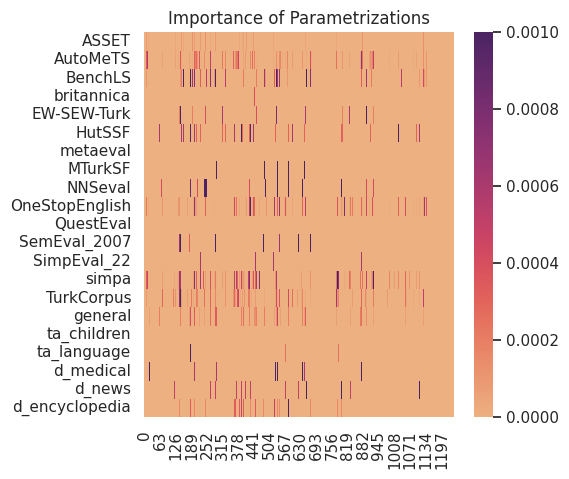

In [31]:
fig = sns.heatmap(imps, vmin=0, vmax=0.001, cmap="flare", yticklabels=names).set_title('Importance of Parametrizations')
sns.set(rc = {'figure.figsize':(15,5)})
fig

In [17]:
import numpy as np

Text(0.5, 1.0, 'Correlation of Parametrizations')

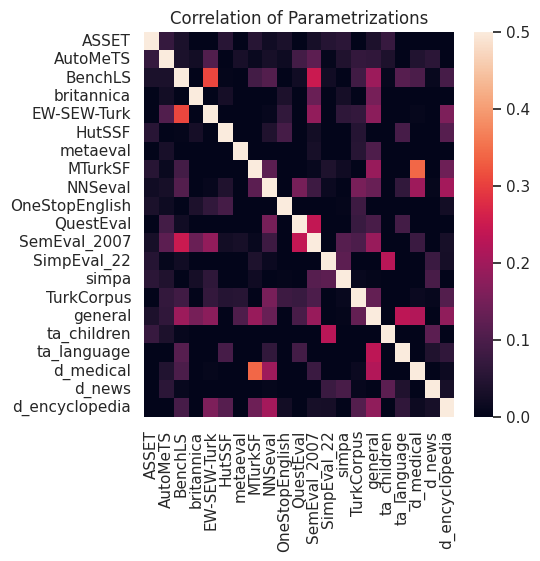

In [32]:
sns.set(rc = {'figure.figsize':(5,5)})

sns.heatmap(np.corrcoef(imps), vmin=0, vmax=0.5, yticklabels=names, xticklabels=names).set_title('Correlation of Parametrizations')

### Interpretation

In [21]:
dims_to_names, names_to_dims, name_to_thresless, name_to_category, name_to_feature = get_mapping_of_LF_and_dims()


In [22]:
para_to_dim = {}
inter_to_dim = {}
feat_to_dim = {}
cat_to_dim = {}

for i in range(len(imps[0])):
    para = dims_to_names[i][0].strip()
    if not para in para_to_dim:
        para_to_dim[para] = len(para_to_dim)

    inter = name_to_thresless[para].strip()
    if not inter in inter_to_dim:
        inter_to_dim[inter] = len(inter_to_dim)

    feat = name_to_feature[para].strip()
    if not feat in feat_to_dim:
        feat_to_dim[feat] = len(feat_to_dim)

    cate = name_to_category[para].strip()
    if not cate in cat_to_dim:
        cat_to_dim[cate] = len(cat_to_dim)

all_para = []
all_int = []
all_feat = []
all_cat = []

for i in range(len(imps)):
    all_para.append([0] * len(para_to_dim))
    all_int.append([0] * len(inter_to_dim))
    all_feat.append([0] * len(feat_to_dim))    
    all_cat.append([0] * len(cat_to_dim))

In [23]:
# fill structures

for i in range(len(imps)):
    for j in range(len(imps[i])):
        c_val = imps[i][j]
        if c_val > 0:
            c_para = dims_to_names[j][0]
            c_int = inter_to_dim[name_to_thresless[c_para]]
            c_feat = feat_to_dim[name_to_feature[c_para]]
            c_cat = cat_to_dim[name_to_category[c_para]]
            
            all_int[i][c_int] += c_val
            all_feat[i][c_feat] += c_val
            all_cat[i][c_cat] += c_val


### Interpretations

Text(0.5, 1.0, 'Importance of Interpretations')

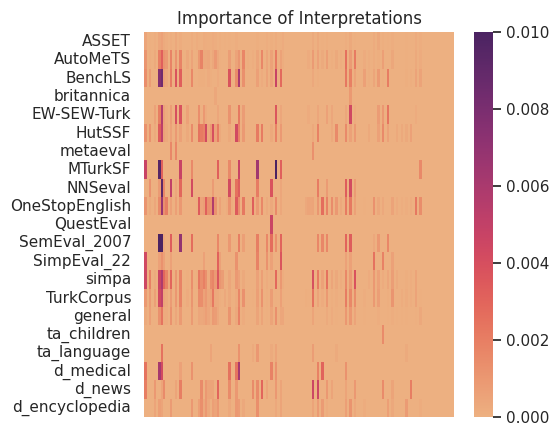

In [33]:
fig = sns.heatmap(all_int, vmin=0, vmax=0.01, cmap="flare", yticklabels=names, xticklabels=[]).set_title('Importance of Interpretations')
sns.set(rc = {'figure.figsize':(5,5)})
fig

Text(0.5, 1.0, 'Correlation of Interpretations')

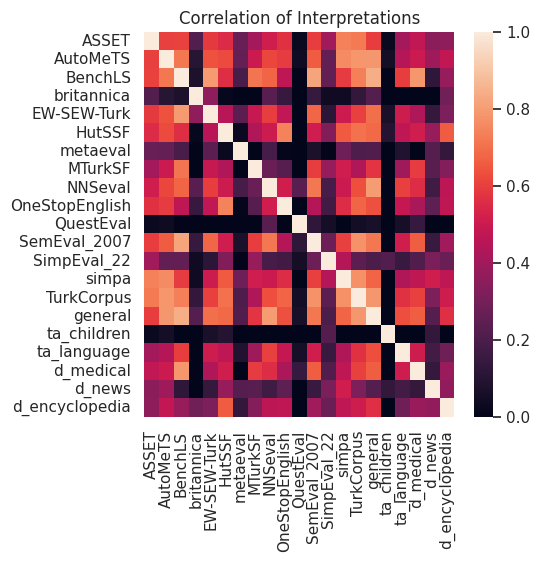

In [34]:
sns.set(rc = {'figure.figsize':(5,5)})

sns.heatmap(np.corrcoef(all_int), vmin=0, vmax=1, yticklabels=names, xticklabels=names).set_title('Correlation of Interpretations')

### Features

In [35]:
feat_names_heatmap = []

d2f = {}

for cf in feat_to_dim:
    d2f[feat_to_dim[cf]] = cf

for i in range(len(d2f)):
    feat_names_heatmap.append(d2f[i])

Text(0.5, 1.0, 'Importace of Features')

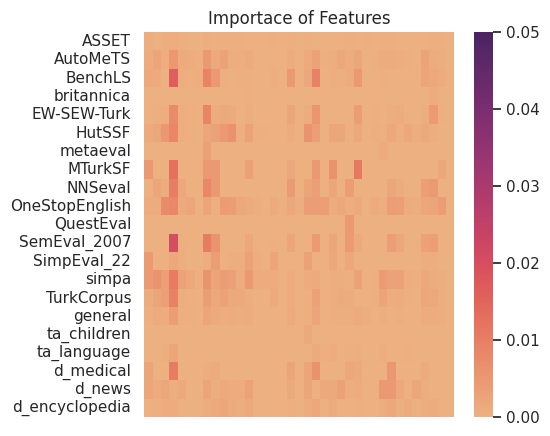

In [36]:
fig = sns.heatmap(all_feat, vmin=0, vmax=0.05, cmap="flare", yticklabels=names, xticklabels=[]).set_title('Importace of Features')
sns.set(rc = {'figure.figsize':(5,5)})
fig

Text(0.5, 1.0, 'Correlation of Features')

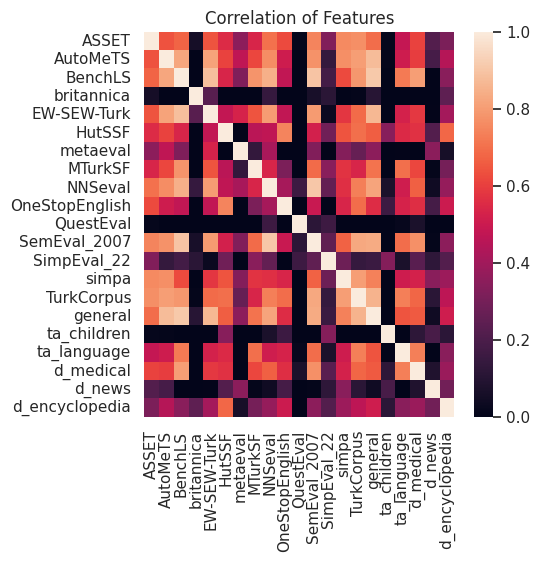

In [37]:
sns.heatmap(np.corrcoef(all_feat), vmin=0, vmax=1, yticklabels=names, xticklabels=names).set_title('Correlation of Features')


### Categories

In [38]:
cat_names_heatmap = []

c2f = {}

for cc in cat_to_dim:
    c2f[cat_to_dim[cc]] = cc

for i in range(len(c2f)):
    cat_names_heatmap.append(c2f[i])

Text(0.5, 1.0, 'Importance of Categories')

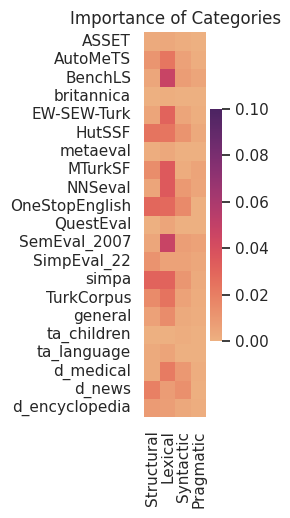

: 

In [43]:
fig = sns.heatmap(all_cat, vmin=0, vmax=0.1, cmap="flare", yticklabels=names, xticklabels=cat_names_heatmap).set_title('Importance of Categories')
sns.set(rc = {'figure.figsize':(1,5)})
fig

Text(0.5, 1.0, 'Correlation of Categories')

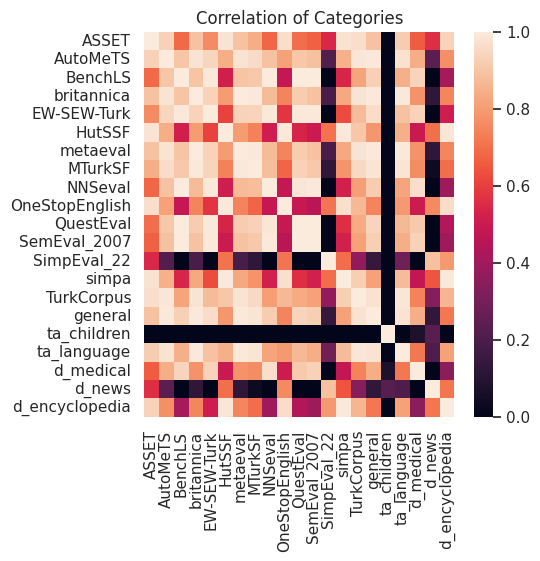

In [40]:
sns.set(rc = {'figure.figsize':(5,5)})
sns.heatmap(np.corrcoef(all_cat), vmin=0, vmax=1, yticklabels=names, xticklabels=names).set_title('Correlation of Categories')
